In [1]:
# Loading our CSV file into a pandas DataFrame
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/online_retail_II.csv')   
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# Renaming column to match column naming convention
df = df.rename(columns={'Customer ID': 'CustomerID'})

# Removing transactions not belonging to an identified customer
df.isna().sum()
df_cleaned = df.dropna(subset=['CustomerID']).copy()

# Removing logical error where quantity is less or equal to 0
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

# Remove cancelled orders
df_cleaned = df_cleaned[~ df_cleaned['Invoice'].str.startswith('c')]



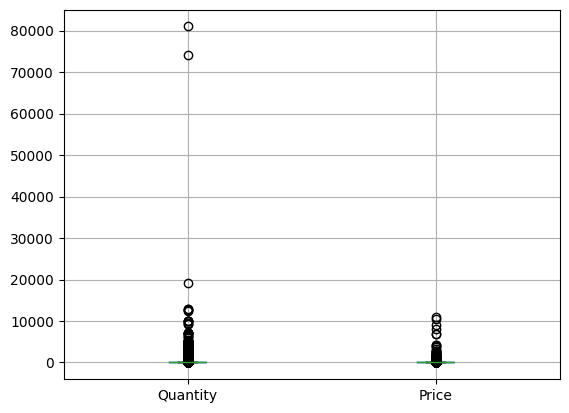

In [3]:
# Changing fields into appropriate data types
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'], format='%Y-%m-%d %H:%M:%S')


# Creating a new column 'TotalPrice' as Quantity multiplied by Price
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['Price']

# Standardizing country naming convention
def country_changes(country_x):
    if country_x == 'EIRE':
        return 'Ireland'
    elif country_x == 'RSA':
        return 'South Africa'
    elif country_x == 'USA':
        return 'United States'
    else:
        return country_x

df_cleaned['Country'] = df_cleaned['Country'].apply(country_changes)
df_cleaned['Country'].value_counts()

# Duplicates
df_cleaned[df_cleaned.duplicated(keep=False)].sort_values(by=list(df_cleaned.columns)).head(10)

# Removing duplicates 
df_cleaned = df_cleaned.drop_duplicates(keep='first')

# Visualizing outliers in Quantity and Price columns
df_cleaned[['Quantity', 'Price']].boxplot()

# Removing outliers in Quantity and Price columns
df_cleaned = df_cleaned[df_cleaned['Quantity'] < 70000]



Data ranges from 2009-12-01 to 2011-12-09


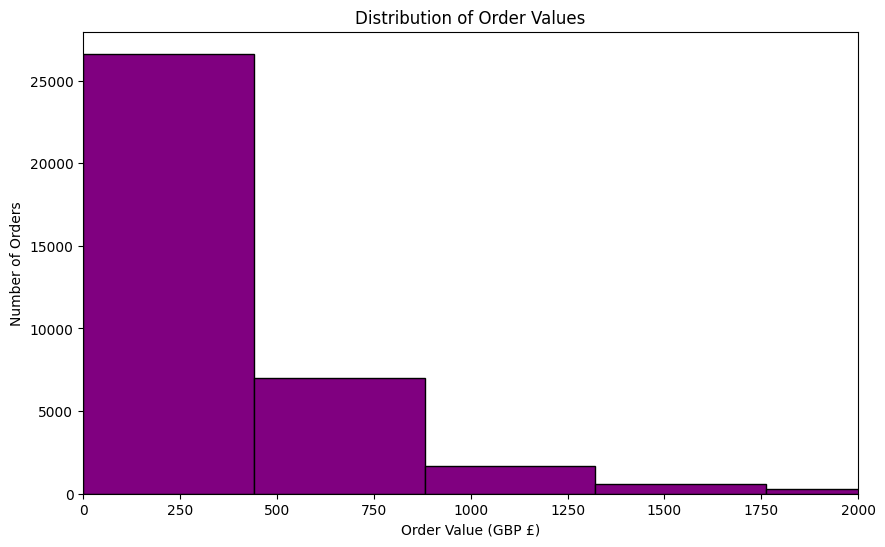

In [ ]:
# Exploratory Data Analysis (EDA)

# Time range
earliest_date = df_cleaned['InvoiceDate'].min()
latest_date = df_cleaned['InvoiceDate'].max()

print(f'Data ranges from {earliest_date.date()} to {latest_date.date()}')

# Top Ten most transactions by country

countries_by_transactions = df_cleaned.groupby('Country')['Invoice'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.bar(countries_by_transactions.index, countries_by_transactions.values, color='skyblue')
plt.title('Top Ten Countries by Transaction Count')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()



# What are the top 10 best-selling products? (by quantity sold)

quantity_sold = df_cleaned.groupby('StockCode').agg({
                                    'Description': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] ,
                                    'Quantity': 'sum'}).sort_values(by='Quantity', ascending=False).head(10)
quantity_sold = quantity_sold.sort_values(by='Quantity')
plt.figure(figsize=(10,6))
plt.barh(quantity_sold['Description'], quantity_sold['Quantity'], color='lightcoral')
plt.title('Top Ten Best-Selling Products by Quantity Sold')
plt.ylabel('Product Description')
plt.xlabel('Total Quantity Sold')
plt.show()

# What are the top 10 products by revenue?
revenue_generated = df_cleaned.groupby('StockCode').agg({
                                        'Description': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0] ,
                                        'TotalPrice': 'sum'}).sort_values(by='TotalPrice', ascending=False).head(10)

revenue_generated = revenue_generated.sort_values(by='TotalPrice', ascending=True)
plt.figure(figsize=(10,6))
plt.barh(revenue_generated['Description'], revenue_generated['TotalPrice'], color='green')
plt.title('Top Ten Best-Selling Products by Quantity Sold')
plt.ylabel('Product Description')
plt.xlabel('Total Revenue Generated (GBP £)')
plt.show()

# What is the distribution of order values? 
order_values = df_cleaned.groupby('Invoice')['TotalPrice'].sum()
plt.figure(figsize=(10,6))
plt.hist(order_values, bins=100, color='purple', edgecolor='black')
plt.title('Distribution of Order Values')
plt.xlabel('Order Value (GBP £)')
plt.ylabel('Number of Orders')
plt.xlim(0, 2000)  #Limiting x-axis for better visualization
plt.show()




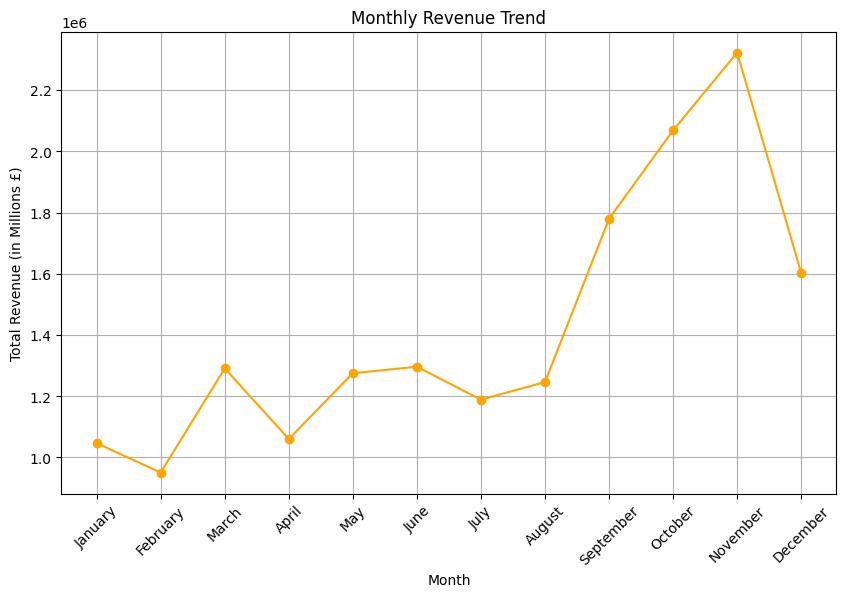

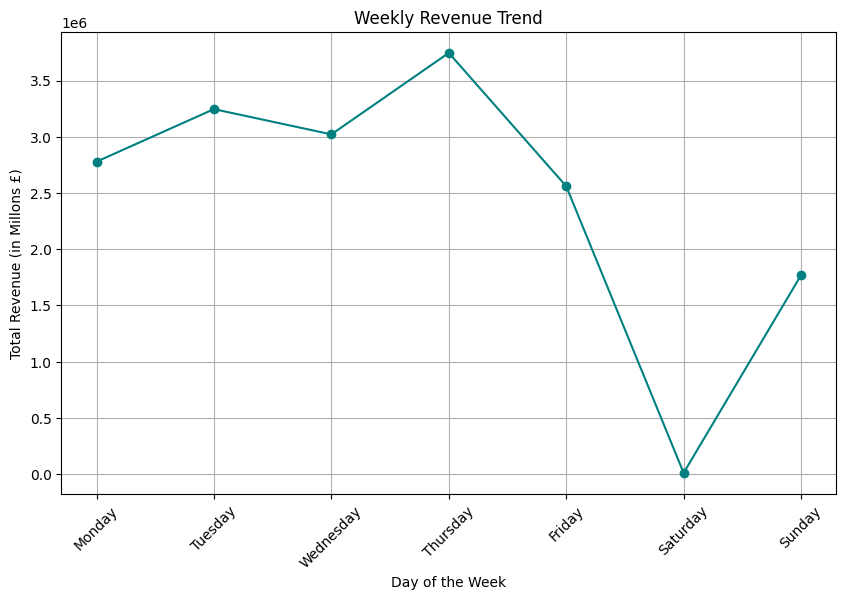

In [68]:
# Time Series Analysis

# Monthly revenue trend
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month_name()
df_cleaned['MonthNum'] = df_cleaned['InvoiceDate'].dt.month

monthly_revenue = df_cleaned.groupby('Month').agg({'TotalPrice': 'sum', 'MonthNum': 'first'}).sort_values(by='MonthNum')
monthly_revenue['TotalPrice'] = monthly_revenue['TotalPrice'].round()

plt.figure(figsize=(10,6))
plt.plot(monthly_revenue.index, monthly_revenue['TotalPrice'], marker='o', color='orange')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue (in Millions £)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


# Which days of the week have the highest sales?
df_cleaned = df_cleaned.drop(columns=['MonthNum', 'Month'])

df_cleaned['Week'] = df_cleaned['InvoiceDate'].dt.day_name()
df_cleaned['WeekNum'] = df_cleaned['InvoiceDate'].dt.day_of_week

week_revenue = df_cleaned.groupby('Week').agg({'TotalPrice': 'sum', 'WeekNum': 'first'}).sort_values(by='WeekNum')
week_revenue['TotalPrice'] = week_revenue['TotalPrice'].round()

plt.figure(figsize=(10,6))
plt.plot(week_revenue.index, week_revenue['TotalPrice'], marker='o', color='teal')
plt.title('Weekly Revenue Trend')         
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue (in Millons £)')
plt.xticks(rotation=45)
plt.grid()
plt.show()




There are 5881 unique customers in the dataset.


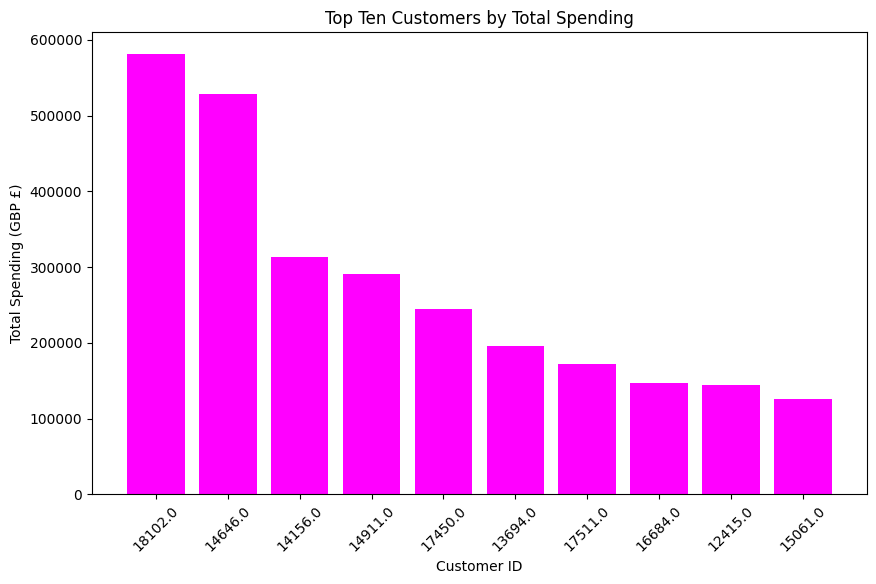

In [95]:
# Customer Analysis
unique_customers = df_cleaned['CustomerID'].unique().size
print(f"There are {unique_customers} unique customers in the dataset.")

# Who are the top 10 customers by total spending?
top_customers = df_cleaned.groupby('CustomerID')['TotalPrice'].sum().nlargest(10)

plt.figure(figsize=(10,6))
plt.bar(top_customers.index.astype(str), top_customers.values, color='magenta')
plt.title('Top Ten Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending (GBP £)')
plt.xticks(rotation=45)
plt.show()

In [88]:
print(unique_customers)

5881
